In [3]:
from typing import List
import numpy as np
import numpy.typing as npt
from Helpers.Classes import LimitOrder, MinMax
from Helpers.CLOB import CLOB
from Helpers.SimulationAbstract import Simulation, SimulationStep
from Helpers.Animation import AnimationOptions, GenerateAnimation

$$
S_{\text{true price}}(t) = \begin{cases}
110 & 0.5 \le t \\
100 & \text{otherwise}
\end{cases}
$$

$$
S_{\text{spread}}(t) = 0.04
$$

$$
O_{\text{order count}}(t) = 15 * V(t) + 5
$$

$$
V_{\text{volatility}}(t) = \begin{cases}
0.025 & 0.8 \le t \\
1.0 & 0.4 \le t \le 0.6 \\
0.2 & \text{otherwise}
\end{cases}
$$

$$
R_{\text{reversion}}(t) = \begin{cases}
30 & 0.8 \le t \\
V_{\text{volatility}}(t) * (5 + 30 * t) & 0.5 \le t \\
V_{\text{volatility}}(t) * 5 & \text{otherwise}
\end{cases}
$$

$$
A_{\text{adjustment factor}}(t) = \sqrt{O_{\text{order count}}(t)}
$$

$$
V_{\text{adjusted}}(t) = 3 * A_{\text{adjustment factor}}(t) * V_{\text{volatility}}(t) 
$$

$$
R_{\text{adjusted}}(t) = A_{\text{adjustment factor}}(t) * R_{\text{reversion}}(t)
$$

$$
G(t, c) = c + \epsilon\frac{S_{\text{spread}}}{2} + R_{\text{adjusted}}(t)(S_{\text{true price}}(t)  - c)dt + V_{\text{adjusted}}(t)\sqrt{c dt}N(0, 1)
$$

Where $G$ is the order generating function and $c$ is the top bid/ask price and $N(0,1)$ is a sample of the normal distribution. When generating bids $\epsilon = -1$, when generating asks $\epsilon = +1$.


In [4]:
class OrderSDE_V1():
    _rng: np.random.Generator
    
    def __init__(self, rng: np.random.Generator):
        self._rng = rng
        pass
    
    def get_order_count(self, t: float, dt: float) -> int:
        return int(15 * self._unadjusted_volatility(t) + 5)
    
    def _adjustment_factor(self, order_count: int) -> float:
        return np.sqrt(order_count)
    
    def _unadjusted_volatility(self, t: float) -> float:
        if 0.8 <= t:
            return 0.025
        elif 0.4 <= t <= 0.6:
            return 1.0
        else:
            return 0.2
    
    def get_volatility(self, t: float, dt: float) -> float:
        return 3.0 * self._adjustment_factor(self.get_order_count(t, dt)) * self._unadjusted_volatility(t)
    
    def _unadjusted_reversion(self, t: float) -> float:
        if 0.8 <= t:
            return 30.0
        elif 0.5 <= t:
            return self._unadjusted_volatility(t) * (5.0 + 30 * t)
        else:
            return self._unadjusted_volatility(t) * 5.0
    
    def _get_reversion(self, t: float, dt: float) -> float:
        return self._adjustment_factor(self.get_order_count(t, dt)) * self._unadjusted_reversion(t)
    
    def get_spread(self, t: float, dt: float) -> float:
        return 0.04
    
    def get_stock_price(self, t: float, dt: float) -> float:
        if 0.5 <= t:
            return 110.0
        else:
            return 100.0
    
    def generate_bid_price_array(self, price: float, t: float, dt: float) -> npt.NDArray[np.float64]:
        order_count = self.get_order_count(t, dt)
        half_spread = self.get_spread(t, dt) / 2.0
        target = self.get_stock_price(t, dt)
        volatility = self.get_volatility(t, dt)
        reversion = self._get_reversion(t, dt)
        
        return price - half_spread \
               + reversion * (target - price) * dt \
               + volatility * np.sqrt(price * dt) \
               * self._rng.normal(loc=0.0, scale=1.0, size=order_count)
    
    def generate_ask_price_array(self, price: float, t: float, dt: float) -> npt.NDArray[np.float64]:
        order_count = self.get_order_count(t, dt)
        half_spread = self.get_spread(t, dt) / 2.0
        target = self.get_stock_price(t, dt)
        volatility = self.get_volatility(t, dt)
        reversion = self._get_reversion(t, dt)
        
        return price + half_spread \
               + reversion * (target - price) * dt \
               + volatility * np.sqrt(price * dt) \
               * self._rng.normal(loc=0.0, scale=1.0, size=order_count)
    pass


class SimulationOrderSDE_V1(Simulation):
    clob: CLOB
    T: float
    N: int
    order_model: OrderSDE_V1
    removal_percentage: float
    _rng: np.random.Generator
    _action_count: int
    _timestamp: int
    
    def __init__(self, 
                 T: float, 
                 N: int, 
                 order_model: OrderSDE_V1,
                 removal_percentage: float,
                 rng: np.random.Generator,
                ):
        self.clob = CLOB()
        self.T = T
        self.N = N
        self.order_model = order_model
        self.removal_percentage = removal_percentage
        self._rng = rng
        self._action_count = 0
        self._timestamp = 0
        pass
    
    def get_N(self) -> int:
        return self.N
    
    def _remove_orders(self, percent: float):
        # Remove some percent of random orders
        bid_ids = self.clob.get_all_bid_ids()        
        if (k := int(len(bid_ids) * percent)) > 0:
            bids_to_remove = list(self._rng.choice(a=bid_ids, size=k, replace=False))
            for bid_id in bids_to_remove:
                self.clob.cancel_bid(bid_id)        
            
        ask_ids = self.clob.get_all_ask_ids()
        if (k := int(len(ask_ids) * percent)) > 0:            
            asks_to_remove = list(self._rng.choice(a=ask_ids, size=k, replace=False))
            for ask_id in asks_to_remove:
                self.clob.cancel_ask(ask_id)
        pass
    
    def do_simulation_step(self) -> SimulationStep:
        if self._timestamp > self.N:
            raise Exception("Simulation is finished")
        
        dt = self.T / self.N
        t = self._timestamp * dt
        ORDERS_COUNT = self.order_model.get_order_count(t, dt)
        ORDERS_SIZE = MinMax(min=1, max=5)
        
        if t == 0.0:
            # initialize the book
            price_distribution  = self._rng.uniform(0.75, 1.0, size=ORDERS_COUNT)
            volume_distribution = self._rng.integers(ORDERS_SIZE.min, ORDERS_SIZE.max, size=ORDERS_COUNT)
            target = self.order_model.get_stock_price(t, dt)
            volatility = self.order_model.get_volatility(t, dt)
            SPREAD = self.order_model.get_spread(t, dt)
            HALF_SPREAD = SPREAD / 2

            bid_top_price = round(target - HALF_SPREAD, 2)
            bid_bottom_price = round(bid_top_price - 0.5 * volatility * bid_top_price, 2)
            bid_prices: List[float] = list(bid_top_price * price_distribution + bid_bottom_price * (1.0 - price_distribution))
            
            ask_bottom_price = round(target + HALF_SPREAD, 2)
            ask_top_price = round(ask_bottom_price + 0.5 * volatility * ask_bottom_price, 2)
            ask_prices: List[float] = list(ask_bottom_price * price_distribution + ask_top_price * (1.0 - price_distribution))
            
            for i, bid_price in enumerate(bid_prices):
                self.clob.submit_bid(LimitOrder(price=bid_price, timestamp=0, quantity=volume_distribution[i], id=self._action_count))
                self._action_count += 1
            
            for i, ask_price in enumerate(ask_prices):
                self.clob.submit_ask(LimitOrder(price=ask_price, timestamp=0, quantity=volume_distribution[i], id=self._action_count))
                self._action_count += 1
            pass
        else:  
            self._remove_orders(self.removal_percentage)
            
            top_bid_price = self.clob.top_bid().price
            top_ask_price = self.clob.top_ask().price
            
            bid_prices = self.order_model.generate_bid_price_array(top_bid_price, t, dt)
            ask_prices = self.order_model.generate_ask_price_array(top_ask_price, t, dt)
            
            bid_quantities = self._rng.integers(ORDERS_SIZE.min, ORDERS_SIZE.max, size=ORDERS_COUNT) 
            for i, bid_price in enumerate(bid_prices):
                self.clob.submit_bid(LimitOrder(price=round(bid_price, 2), timestamp=self._timestamp, quantity=bid_quantities[i], id=self._action_count))
                self._action_count += 1
                pass
            
            ask_quantities = self._rng.integers(ORDERS_SIZE.min, ORDERS_SIZE.max, size=ORDERS_COUNT) 
            for i, ask_price in enumerate(ask_prices):
                self.clob.submit_ask(LimitOrder(price=round(ask_price, 2), timestamp=self._timestamp, quantity=ask_quantities[i], id=self._action_count))
                self._action_count += 1
                pass
            pass
        
        transactions = self.clob.process_transactions()
        depths = self.clob.get_cumulative_depth()
        
        top_bid_price = self.clob.top_bid().price
        top_ask_price = self.clob.top_ask().price
        
        self._timestamp += 1
        return SimulationStep(
            transactions=transactions,
            depths=depths,
            top_bid=top_bid_price,
            top_ask=top_ask_price
        )
    pass

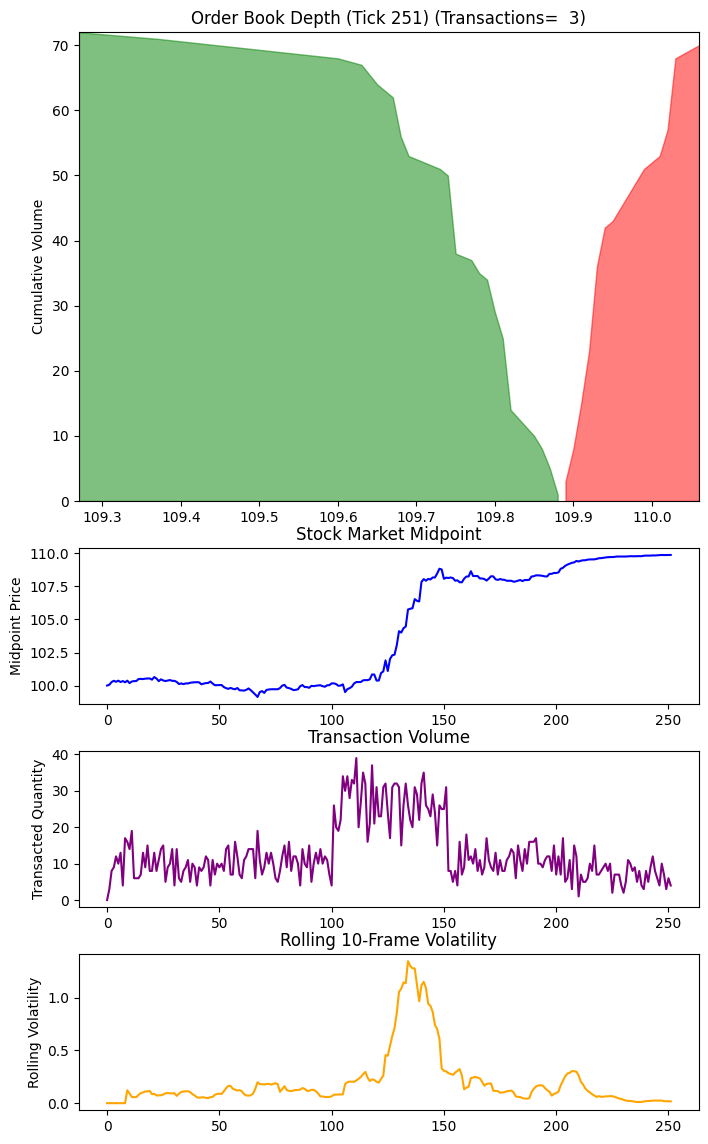

In [5]:
rng = np.random.default_rng(42)
simulation = SimulationOrderSDE_V1(
    T=1.0, 
    N=252, 
    order_model=OrderSDE_V1(rng),
    removal_percentage=0.1,
    rng=rng,
)

options = AnimationOptions(
    figure_size=(8, 14),
    show_order_book=True,
    show_midpoint=True,
    show_volume=True,
    show_volatility=True,
    generate_filename="CLOB_09.demo.mp4",
    fps=10,
    show_plot=True
)
GenerateAnimation(simulation, options)